Assignment 1, Varun Vashishtha, 2022201061


1. [1 point] For the given image calib-object.jpg, identify the chessboard internal corners. You may use external
libraries to detect the chessboard corners. Note, each square of the chess board is 2cm × 2cm.

In [18]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

USING HARRIS CORNER (ALL POINTS) but it detects extra points also 

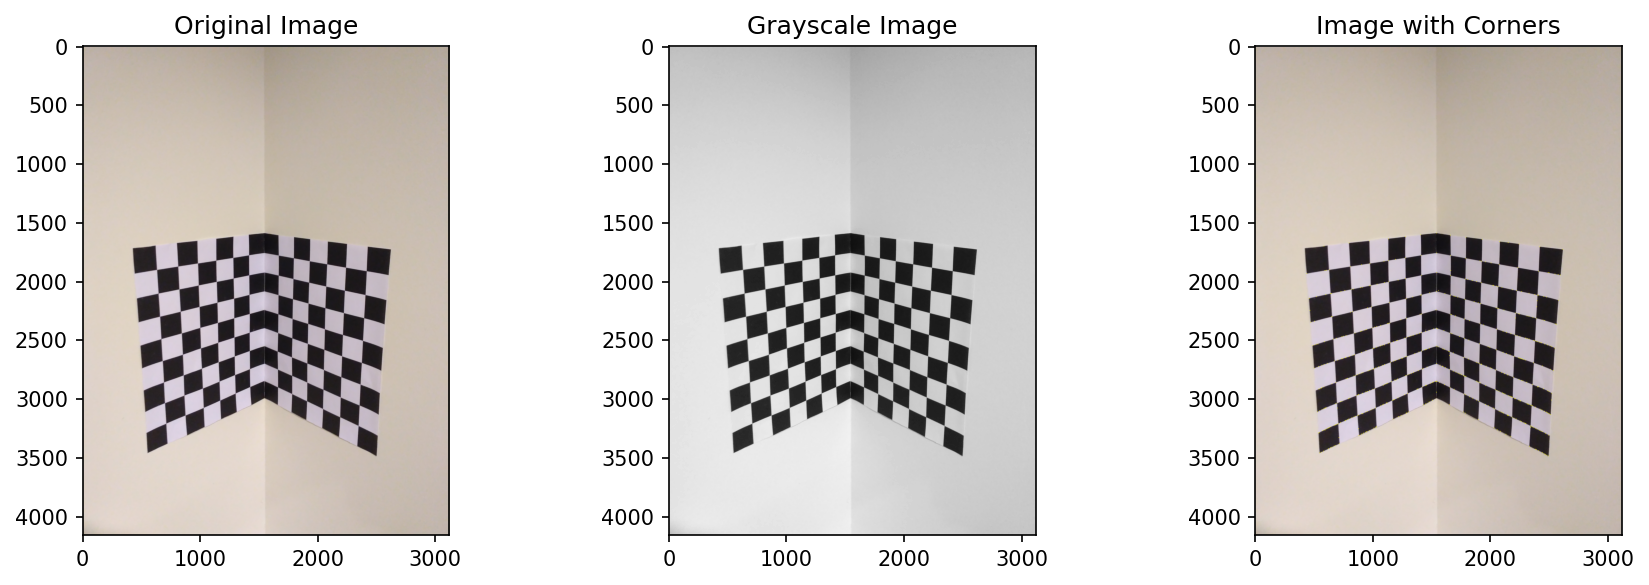

In [23]:


filename = 'calib-object.jpg'
img = cv.imread(filename)
img_with_corners = img.copy()
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv.cornerHarris(gray, 2, 3, 0.04)

# Refine corner locations
dst = cv.dilate(dst, None)
ret, dst = cv.threshold(dst, 0.05 * dst.max(), 255, 0)
dst = np.uint8(dst)

# Find centroids of corners
ret, labels, stats, centroids = cv.connectedComponentsWithStats(dst)

# Define the criteria for corner sub-pixel accuracy
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv.cornerSubPix(gray, np.float32(centroids), (5, 5), (-1, -1), criteria)

# Draw corners on the image
for corner in corners:
    x, y = corner.ravel()
    cv.circle(img_with_corners, (int(x), int(y)), 3, (0, 255, 255), -1)

# Set higher dpi for better quality
plt.figure(figsize=(12, 4), dpi=150)

plt.subplot(131), plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)), plt.title('Original Image')
plt.subplot(132), plt.imshow(gray, cmap='gray'), plt.title('Grayscale Image')
plt.subplot(133), plt.imshow(cv.cvtColor(img_with_corners, cv.COLOR_BGR2RGB)), plt.title('Image with Corners')

cv.imwrite('gray.jpg', gray)
cv.imwrite('img_with_corners.jpg', img_with_corners)

plt.tight_layout()
plt.show()


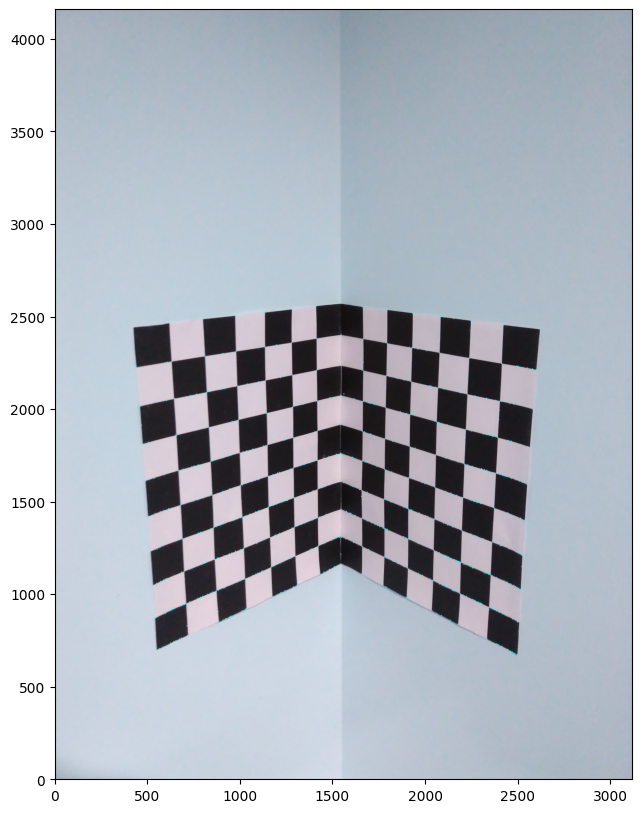

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))  

plt.imshow(img_with_corners, extent=[0, img_with_corners.shape[1], 0, img_with_corners.shape[0]])
plt.show()


USING EXTERNAL LIBRARY(for fine grained corners)

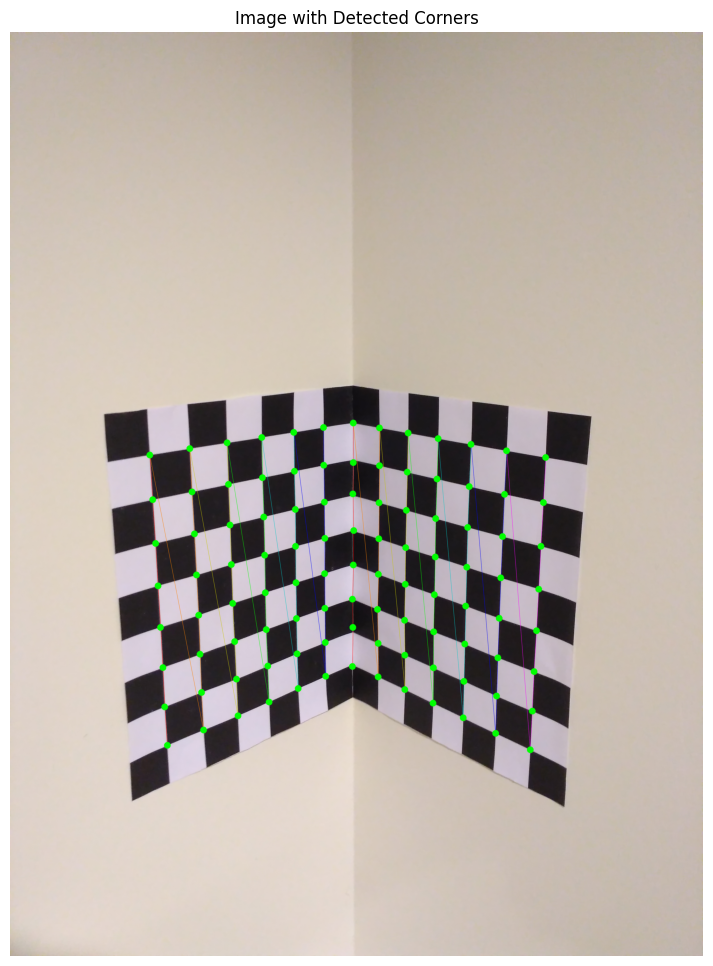

In [27]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread('calib-object.jpg')

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

pattern_right = (8, 7)
pattern_left = (8, 6)  

flags = cv2.CALIB_CB_EXHAUSTIVE + cv2.CALIB_CB_ACCURACY

ret_right, corners_right = cv2.findChessboardCornersSB(gray_image, pattern_right, flags=flags)
ret_left, corners_left = cv2.findChessboardCornersSB(gray_image, pattern_left, flags=flags)

if ret_right and ret_left:
    image_with_corners = cv2.drawChessboardCorners(image.copy(), pattern_right, corners_right, ret_right)
    for corner in corners_right:
        x, y = corner.ravel()  
        cv2.circle(image_with_corners, (int(x), int(y)), 5, (0, 255, 0), 20)

    image_with_corners = cv2.drawChessboardCorners(image_with_corners, pattern_left, corners_left, ret_left)
    for corner in corners_left:
        x, y = corner.ravel()  
        cv2.circle(image_with_corners, (int(x), int(y)), 5, (0, 255, 0), 20) 

    plt.figure(figsize=(12, 12))
    plt.imshow(cv2.cvtColor(image_with_corners, cv2.COLOR_BGR2RGB))
    plt.title('Image with Detected Corners')
    plt.axis('off')  
    plt.show()

else:
    print("Checkerboard corners not found.")


2. [1.5 points] Implement the camera calibration process discussed in the lecture. Assume a world origin, create a
set of corresponding points in the world coordinate and image plane, compute both extrinsics (translation vector,
rotation matrix) and intrinsics (assume no skew) without using any external libraries for the calib-object.jpg
image.

NOTE HERE I HAVE MANUALLY TAKEN PIXELS VALUES USING MOUSE CALLBACKS BUT IN LATER HALF I DIRECTLY USED TEH CORNERS FOUND FROM THE CORNER DETECTION ALGORITHM

In [6]:
point_names = {}

MOUSE CALLBACK TO FIND THE PIXELS VALUES MANUALLY

In [15]:
import cv2 as cv

img = cv.imread('img_with_corners.jpg')

if img is None:
    print("Error: Could not read the image.")
    exit()


def mouse_callback(event, x, y, flags, param):
    if event == cv.EVENT_LBUTTONDOWN:
        point_name = input(f"Enter a name for the point at ({x}, {y}): ")

        point_names[point_name] = (x, y)

        # Draw the point and name on the image
        cv.circle(img, (x, y), 5, (0, 255, 0), -1)
        cv.putText(img, point_name, (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 2, cv.LINE_AA)
        cv.imshow('Image', img)

# Create a window and set the callback function
cv.namedWindow('Image')
cv.setMouseCallback('Image', mouse_callback)

while True:
    resize_factor = 0.2 
    height, width = img.shape[0], img.shape[1]
    resized_img = cv.resize(img, (int(width * resize_factor), int(height * resize_factor)))
    cv.imshow('Image', resized_img)
    key = cv.waitKey(1)
    if key == 27:  # Press 'Esc' to exit
        break

cv.destroyAllWindows()


In [17]:
# Example usage:
image_points = []
world_points = []

for val, (x, y) in point_names.items():
    image_points.append(np.array([x, y]))
    a, b, c = val.split(",")
    # print(a, b, c)
    # world_points.append([int(a), int(b), int(c)])
    world_points.append([int(c), int(b), int(a)])

world_points = np.array(world_points)
image_points = np.array(image_points)

print(world_points)
print(image_points)

[[ 0 14  0]
 [ 0  0  0]
 [ 0  0 14]
 [16  0 14]
 [16  0  0]
 [16 14  0]
 [ 8  8  0]
 [ 8  0  8]]
[[ 86 347]
 [309 320]
 [524 349]
 [499 698]
 [309 601]
 [111 692]
 [199 482]
 [412 483]]


TAKING VARIOUS POINTS AND THEN SOLVING THEM TO GET THE PROJECTION  MATRIX

In [18]:
import numpy as np
from numpy.linalg import svd

def estimate_projection_matrix(image_points, world_points):
    num_points = len(image_points)

    # Construct the A matrix for the DLT method
    A = np.zeros((2 * num_points, 12))

    for i in range(num_points):
        X, Y, Z = world_points[i]
        x, y = image_points[i]

        A[2*i, :] = [-X, -Y, -Z, -1, 0, 0, 0, 0, x*X, x*Y, x*Z, x]
        A[2*i + 1, :] = [0, 0, 0, 0, -X, -Y, -Z, -1, y*X, y*Y, y*Z, y]

    qt, kt, Vt = svd(A)

    print(qt.shape, kt.shape, Vt.shape)
    
    P = Vt[-1, :].reshape(3, 4)

    return P



projection_matrix = estimate_projection_matrix(image_points, world_points)
print("Projection Matrix:")
print(projection_matrix)


(16, 16) (12,) (12, 12)
Projection Matrix:
[[-2.55966067e-03  3.82715989e-02 -1.48111785e-02 -6.95742085e-01]
 [-4.40743760e-02  7.85633877e-03  8.35519332e-03 -7.15662742e-01]
 [-8.38883341e-06  3.46037044e-05  3.65221084e-05 -2.25138455e-03]]


In [19]:
np.sum(projection_matrix)

-1.420555558298672

In [25]:
import numpy as np

def rq_decomposition_projection_matrix(P):
    Q, T = np.linalg.qr(P.T)

    # Intrinsic Matrix
    K = np.linalg.inv(T)
    print("SHAPES :", Q.shape, T.shape)
    K /= K[2, 2]

    # Get the rotation matrix R
    R = np.dot(np.linalg.inv(K), P)
    
    reconstruct = np.dot(K, R)
    print("REC", reconstruct)
    return K, R, reconstruct


R, Q, reconstruct = rq_decomposition_projection_matrix(projection_matrix)

print("Projection Matrix P:")
print(projection_matrix)

print("\nIntrinsic MatrixR:")
print(R)

print("\nOrthogonal Matrix Q:")
print(Q)

# Verify the decomposition: P = RQ
verification = np.dot(Q.T, R)
print("\nVerification (Q^T * R):")
print(verification)


SHAPES : (4, 3) (3, 3)
REC [[ 3.98729913e+03  2.77633836e+02 -1.77204501e+03  1.48618623e+04]
 [ 8.00980165e+02  4.23672388e+03  5.70809565e+02  6.20092653e+04]
 [ 7.38655497e-01  1.99827288e-01  6.43783436e-01  3.56748273e+01]]
Projection Matrix P:
[[ 3.98729913e+03  2.77633836e+02 -1.77204501e+03  1.48618623e+04]
 [ 8.00980165e+02  4.23672388e+03  5.70809565e+02  6.20092653e+04]
 [ 7.38655497e-01  1.99827288e-01  6.43783436e-01  3.56748273e+01]]

Intrinsic MatrixR:
[[ 1.43253098e-04 -4.94340329e-04 -1.12982579e-04]
 [ 0.00000000e+00  1.28265795e-04 -5.45920876e-04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Orthogonal Matrix Q:
[[4.93832462e+07 1.15921393e+08 2.98683998e+06 1.77202144e+09]
 [6.24469341e+06 3.30308168e+07 4.45021149e+06 4.83443653e+08]
 [7.38655497e-01 1.99827288e-01 6.43783436e-01 3.56748273e+01]]

Verification (Q^T * R):
[[ 7.07430301e+03 -2.36111496e+04 -8.98781635e+03]
 [ 1.66060987e+04 -5.30678957e+04 -3.11291105e+04]
 [ 4.27874081e+02 -9.05705543e+02 -

3. [1 point] Use the real-world measurements along with the estimated camera parameters to compute the image
of a wireframe of the object (Hint: the wireframe is the outer corners of the actual chessboard pattern and has
6 points). Note that you should compute the location of image points as xi = PXi, where P is the projection
matrix computed above. Overlay (draw) the wireframe over the actual image of the object using straight lines
between the computed points xi. What do you observe about the overlay?

Shape : (6, 4) (3, 4) (3, 4)
[[-0.1599397  -0.605674   -0.00176693]
 [ 0.69574208  0.71566274  0.00225138]
 [-0.90309858 -0.59869004 -0.00174008]
 [-0.94405315 -1.30388005 -0.0018743 ]
 [-0.73669666 -1.42085276 -0.00238561]
 [-0.20089427 -1.31086401 -0.00190115]]
new_mat : [[ 450 1710]
 [1545 1585]
 [2590 1720]
 [2515 3475]
 [1540 2975]
 [ 525 3445]]


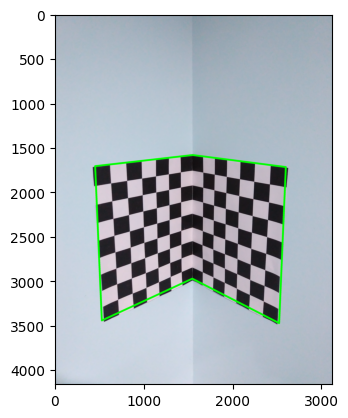

In [21]:
import numpy as np
import cv2

P = projection_matrix
K = Q

# CORNER POINTS IN WORLD COORDINATES
wireframe_points_3d = np.array([[ 0, 14 , 0], [ 0,  0,  0], [ 0,  0,14], [16 , 0 ,14], [16,  0,  0], [16 ,14,  0]], dtype=np.float32)

wireframe_points_homogeneous = np.hstack((wireframe_points_3d, np.ones((wireframe_points_3d.shape[0], 1))))

print("Shape :",  wireframe_points_homogeneous.shape, K.shape, P.shape)
wireframe_points_2d = np.dot(P, wireframe_points_homogeneous.T)


# FINDING IMAGE POINTS FROM WORLD COORDINATES
temp = wireframe_points_2d
for val in wireframe_points_2d:
    val[1] = -1*val[1]
wireframe_points_2d = wireframe_points_2d.T
print(wireframe_points_2d)
new_mat = []
for val in wireframe_points_2d:
    new_mat.append([int(val[0]/val[2])*5, int(val[1]/val[2])*5])
new_mat = np.array(new_mat)
img = cv2.imread('calib-object.jpg')


print("new_mat :", new_mat)
# Overlay the wireframe on the actual image
for i in range(6):
    cv2.circle(img, tuple(new_mat[i].astype(int)), 5, (0, 255, 0), -1)

# Draw lines between wireframe points to form the wireframe
cv2.line(img, tuple(new_mat[0].astype(int)), tuple(new_mat[1].astype(int)), (0, 255, 0), 20)
cv2.line(img, tuple(new_mat[1].astype(int)), tuple(new_mat[2].astype(int)), (0, 255, 0), 20)
cv2.line(img, tuple(new_mat[2].astype(int)), tuple(new_mat[3].astype(int)), (0, 255, 0), 20)
cv2.line(img, tuple(new_mat[3].astype(int)), tuple(new_mat[4].astype(int)), (0, 255, 0), 20)
cv2.line(img, tuple(new_mat[4].astype(int)), tuple(new_mat[5].astype(int)), (0, 255, 0), 20)
cv2.line(img, tuple(new_mat[5].astype(int)), tuple(new_mat[0].astype(int)), (0, 255, 0), 20)

# Display the image with overlay
resize_factor = 0.2  # Adjust this factor as needed
height, width = img.shape[0], img.shape[1]
resized_img = cv.resize(img, (int(width * resize_factor), int(height * resize_factor)))
cv.imshow('Image', resized_img)
cv2.imwrite('QUESTION_1_wireFrame.jpg', gray, None)

plt.imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()




4. [0.5 points] Given the rotation matrix, compute the three rotation angles. Explain the values that you obtain in
terms of pan, tilt, and roll?

In [26]:
def rotation_matrix_to_euler_angles(R):
    sy = np.sqrt(R[0, 0] * R[0, 0] + R[1, 0] * R[1, 0])
    singular = sy < 1e-6

    if not singular:
        x = np.arctan2(R[2, 1], R[2, 2])
        y = np.arctan2(-R[2, 0], sy)
        z = np.arctan2(R[1, 0], R[0, 0])
    else:
        x = np.arctan2(-R[1, 2], R[1, 1])
        y = np.arctan2(-R[2, 0], sy)
        z = 0

    return np.degrees(x), np.degrees(y), np.degrees(z)

roll, pitch, yaw = rotation_matrix_to_euler_angles(Q)

print("ROTATION MATRIX :",Q)
print("Roll (X-axis rotation): {:.2f} degrees".format(roll))
print("Pitch (Y-axis rotation): {:.2f} degrees".format(pitch))
print("Yaw (Z-axis rotation): {:.2f} degrees".format(yaw))



"""The function rotation_matrix_to_euler_angles(R) converts a 3x3 rotation matrix R to Euler angles, representing rotations about the x-axis (roll), y-axis (pitch), 
and z-axis (yaw). Here's a step-by-step explanation of the function:

Singular Check:

It first checks if the rotation matrix is singular (i.e., if sy is close to zero). A singular matrix can occur when there is gimbal lock or when the 
rotation is near certain singularities. Gimbal lock happens when one axis aligns with another, leading to a loss of one degree of freedom in representing rotations.
Calculating Euler Angles:

If the matrix is not singular, it computes the Euler angles x, y, and z using trigonometric functions (np.arctan2()). These equations are based on 
the rotation matrix elements and provide the rotation angles about the x, y, and z axes respectively. If the matrix is singular, it handles the special 
case separately, calculating the angles differently. Converting to Degrees:

After computing the angles in radians, it converts them to degrees using np.degrees().

Return Values:

The function returns the calculated roll (x), pitch (y), and yaw (z) angles in degrees.
The print statements then display the rotation matrix Q and the corresponding Euler angles (roll, pitch, and yaw) in degrees.

These Euler angles represent the orientation of an object in 3D space. Roll is the rotation around the x-axis, pitch is the rotation around the y-axis, and yaw
 is the rotation around the z-axis. By applying these rotations sequentially, you can orient an object in any desired direction in 3D space."""

ROTATION MATRIX : [[4.93832462e+07 1.15921393e+08 2.98683998e+06 1.77202144e+09]
 [6.24469341e+06 3.30308168e+07 4.45021149e+06 4.83443653e+08]
 [7.38655497e-01 1.99827288e-01 6.43783436e-01 3.56748273e+01]]
Roll (X-axis rotation): 17.24 degrees
Pitch (Y-axis rotation): -0.00 degrees
Yaw (Z-axis rotation): 7.21 degrees


THROUGH INBUILT FUNCTIONS HERE I AM FINING THE CORNERS DIRECTLY

In [27]:
import numpy as np
import cv2
import glob
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((8*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8,0:8].T.reshape(-1,2)
worldpoints = []
worldpoints.append(objp)
imgpoints = []
# images = glob.glob('img_with_corners.jpg')
img = cv2.imread("calib-object.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


In [4]:

np.mgrid[0:8,0:8].T.reshape(-1,2).shape
print(gray.shape )

left_img, right_img = gray[:, :1545], gray[:, :1545]

cv2.imshow('gray',gray)
# plt.imshow(gray)
cv2.imwrite('gray.jpg', gray, None)
cv2.waitKey(0)

(4160, 3120)


27

In [5]:
ret, corners_left = cv2.findChessboardCorners(left_img, (6, 8))

In [6]:
imgpoints_left = []

if ret == True:
    cv2.cornerSubPix(gray, corners_left[:4], (100, 100), (-1,-1), criteria)
    imgpoints_left.append(corners_left)
    # Draw and display the corners_left
    cv2.drawChessboardCorners(left_img, (7,6), corners_left, ret)
    resize_factor = 1  # Adjust this factor as needed
    height, width = left_img.shape[0], left_img.shape[1]
    left_img = cv2.resize(left_img, (int(width * resize_factor), int(height * resize_factor)))
    cv2.imshow('left_img',left_img)
    cv2.imwrite('corners_left_detected.jpg', left_img, None)
    cv2.waitKey(0)
cv2.destroyAllWindows()


In [7]:
worldpoints_left = []

for y in range(2, 18, 2):
    for x in range(2, 14, 2):
        worldpoints_left.append([x, y, 0])


In [28]:
worldpoints_left

array([[[ 2.,  2.,  0.],
        [ 4.,  2.,  0.],
        [ 6.,  2.,  0.],
        [ 8.,  2.,  0.],
        [10.,  2.,  0.],
        [12.,  2.,  0.],
        [ 2.,  4.,  0.],
        [ 4.,  4.,  0.],
        [ 6.,  4.,  0.],
        [ 8.,  4.,  0.],
        [10.,  4.,  0.],
        [12.,  4.,  0.],
        [ 2.,  6.,  0.],
        [ 4.,  6.,  0.],
        [ 6.,  6.,  0.],
        [ 8.,  6.,  0.],
        [10.,  6.,  0.],
        [12.,  6.,  0.],
        [ 2.,  8.,  0.],
        [ 4.,  8.,  0.],
        [ 6.,  8.,  0.],
        [ 8.,  8.,  0.],
        [10.,  8.,  0.],
        [12.,  8.,  0.],
        [ 2., 10.,  0.],
        [ 4., 10.,  0.],
        [ 6., 10.,  0.],
        [ 8., 10.,  0.],
        [10., 10.,  0.],
        [12., 10.,  0.],
        [ 2., 12.,  0.],
        [ 4., 12.,  0.],
        [ 6., 12.,  0.],
        [ 8., 12.,  0.],
        [10., 12.,  0.],
        [12., 12.,  0.],
        [ 2., 14.,  0.],
        [ 4., 14.,  0.],
        [ 6., 14.,  0.],
        [ 8., 14.,  0.],


In [8]:
temp1 = []
temp = np.array(np.squeeze(imgpoints_left).tolist())

for te in temp:
    temp1.append([te])
temp1 = [temp1]

worldpoints_left = np.array([worldpoints_left], dtype = np.float32)
temp1 = np.array(temp1, dtype = np.float32)

In [9]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(worldpoints_left, temp1, (img.shape[0], img.shape[1]), None, None, flags=cv2.CALIB_FIX_ASPECT_RATIO)

In [10]:
worldpoints_left.shape, temp1.shape

((1, 48, 3), (1, 48, 1, 2))

In [11]:
R = cv2.Rodrigues(rvecs[0])[0]
t = tvecs[0]
Rt = np.concatenate([R,t], axis = -1)
projection_matrix = np.matmul(mtx, Rt)

print(projection_matrix)

[[ 3.98729913e+03  2.77633836e+02 -1.77204501e+03  1.48618623e+04]
 [ 8.00980165e+02  4.23672388e+03  5.70809565e+02  6.20092653e+04]
 [ 7.38655497e-01  1.99827288e-01  6.43783436e-01  3.56748273e+01]]


In [12]:
import numpy as np
import cv2

# Example projection matrix (replace with your estimated matrix)

def plot_image(projection_matrix, world_coordinates, image_name = 'calib-object.jpg'):
    P = projection_matrix
    K = mtx
    for val in world_coordinates:
        val[2] = -1*val[2]
    wireframe_points_3d = world_coordinates
    wireframe_points_homogeneous = np.hstack((wireframe_points_3d, np.ones((wireframe_points_3d.shape[0], 1))))

    print("Shape :",  wireframe_points_homogeneous.shape, K.shape, P.shape)
    wireframe_points_2d = np.dot(P, wireframe_points_homogeneous.T)
    temp = wireframe_points_2d
    # for val in wireframe_points_2d:
    #     val[2] = -1*val[2]
    wireframe_points_2d = wireframe_points_2d.T
    print(wireframe_points_2d)
    new_mat = []
    for val in wireframe_points_2d:
        new_mat.append([int(val[0]/val[2]), int(val[1]/val[2])])
    new_mat = np.array(new_mat)
    img = cv2.imread(image_name)
    size = len(world_coordinates)
    print("new_mat :", new_mat)

    for i in range(size):
        cv2.circle(img, tuple(new_mat[i].astype(int)), 5, (0, 255, 0), 1)

    # Draw lines between wireframe points to form the wireframe
    add = 0
    for i in range(size):
        # add += 4
        cv2.line(img, tuple(new_mat[i].astype(int)), tuple(new_mat[(i+1)%size].astype(int)), (0, 255, 255), 20)

    resize_factor = 0.2  
    height, width = img.shape[0], img.shape[1]
    resized_img = cv2.resize(img, (int(width * resize_factor), int(height * resize_factor)))
    cv2.imshow('Image', resized_img)
    plt.imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()




Shape : (6, 4) (3, 3) (3, 4)
[[1.48618623e+04 6.20092653e+04 3.56748273e+01]
 [7.06840501e+04 7.32229876e+04 4.60160042e+01]
 [9.54926801e+04 6.52316536e+04 3.70030361e+01]
 [1.00490089e+05 1.41492683e+05 4.05999273e+01]
 [7.56814591e+04 1.49484017e+05 4.96128954e+01]
 [1.98592713e+04 1.38270295e+05 3.92717185e+01]]
new_mat : [[ 416 1738]
 [1536 1591]
 [2580 1762]
 [2475 3485]
 [1525 3013]
 [ 505 3520]]


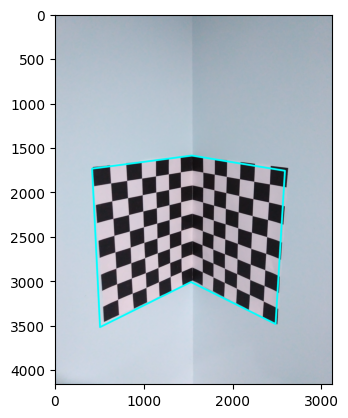

In [13]:
world_coordinates = np.array([[ 0, 0, 0], [14, 0, 0], [14, 0, 14], [14, 18, 14], [14, 18, 0], [0, 18, 0]], dtype=np.float32)

plot_image(projection_matrix, world_coordinates, 'calib-object.jpg')

In [16]:
import numpy as np
import cv2

def rotation_vector_to_rotation_matrix(rotation_vector):
    """
    Convert a rotation vector to a 3x3 rotation matrix.
    """
    rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
    return rotation_matrix

def rotation_matrix_to_euler_angles(rotation_matrix):
    """
    Convert a 3x3 rotation matrix to Euler angles (yaw, pitch, roll).
    """
    # Extract individual rotation angles
    theta_x = np.arctan2(rotation_matrix[2, 1], rotation_matrix[2, 2])
    theta_y = np.arctan2(-rotation_matrix[2, 0], np.sqrt(rotation_matrix[2, 1]**2 + rotation_matrix[2, 2]**2))
    theta_z = np.arctan2(rotation_matrix[1, 0], rotation_matrix[0, 0])

    # Convert angles from radians to degrees
    theta_x = np.degrees(theta_x)
    theta_y = np.degrees(theta_y)
    theta_z = np.degrees(theta_z)

    return theta_x, theta_y, theta_z

# Assuming rvecs contains rotation vectors
rotation_matrices = [rotation_vector_to_rotation_matrix(rotation_vector) for rotation_vector in rvecs]

# Compute Euler angles for each rotation matrix
for rotation_matrix in rotation_matrices:
    theta_x, theta_y, theta_z = rotation_matrix_to_euler_angles(rotation_matrix)

    # Print the Euler angles
    print("Yaw (Pan): {:.2f} degrees".format(theta_z))
    print("Pitch (Tilt): {:.2f} degrees".format(theta_y))
    print("Roll: {:.2f} degrees".format(theta_x))


Yaw (Pan): -11.52 degrees
Pitch (Tilt): -47.62 degrees
Roll: 17.24 degrees


Challenges and problems : 
1) understanding the problem and how to get world and image coordinates
2) Understanding how to use various opencv functions eg findChessboardCorners, alliberateCamera etc
3) plotting the wireframe on the image means how to plot a new thing on the same image 
4) selecting what algorithm to use
5) Troubleshooting and Debugging ate a lot of time

Learnings : 
From the above assignments involving camera calibration, projection matrices, wireframe overlay, and chessboard pattern projection, several key learning points can be derived:

Camera Calibration: Understanding the process of camera calibration is crucial for obtaining accurate intrinsic and extrinsic camera parameters. This involves capturing calibration images with known calibration patterns, detecting feature points, and estimating the camera parameters using calibration algorithms.

Projection Matrices: Learning about projection matrices and their role in transforming 3D world coordinates into 2D image coordinates is essential. This includes understanding how intrinsic and extrinsic parameters are combined to form the projection matrix and how it is used to project points onto the image plane.

Wireframe Overlay: Overlaying wireframe models onto images provides a visual representation of 3D objects in the image. This involves transforming 3D object coordinates into 2D image coordinates using projection matrices and rendering wireframe models onto images using appropriate rendering techniques.

Chessboard Pattern Projection: Projecting chessboard patterns onto images serves as a calibration step to validate the accuracy of camera calibration. This involves projecting known patterns onto images using projection matrices and comparing the projected patterns with detected feature points.

Ambiguity and Challenges: Dealing with ambiguity and challenges in camera calibration, such as coplanar points, lens distortion, and noise, requires careful consideration and appropriate handling techniques. This includes understanding the limitations and potential sources of error in the calibration process.

Visualization and Interpretation: Visualizing and interpreting the results of camera calibration, wireframe overlay, and pattern projection are essential for understanding the geometric relationships between 3D objects and 2D images. This involves analyzing visualizations and drawing conclusions about the accuracy and reliability of the calibration process.

Practical Skills: Developing practical skills in computer vision, image processing, and geometric transformations is essential for implementing calibration algorithms, projection techniques, and rendering methods effectively.

Overall, the assignments provide valuable insights into the theoretical concepts and practical aspects of camera calibration and geometric transformations, enhancing understanding and proficiency in computer vision and image processing tasks.